In [1]:
%matplotlib notebook

import datetime
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6.0, 4.0)

import load_hats

start_day, end_day = '2016-06-01', '2018-05-31'

In [2]:
def read_met(site, yyyy):
    met_ftp = f'/aftp/met/{site}/'
    met_file = f'met_{site}_insitu_1_obop_hour_{yyyy}.txt'
    df = pd.read_csv(met_ftp+met_file, 
                delim_whitespace=True,
                names=['site','year','month','day','hour','wind_dir','wind_speed','wind_steady','press','temp2','temp10','jj','jk','jl'],
                parse_dates = {'date':[1,2,3,4]},
                infer_datetime_format=True,
                index_col='date',
                na_values=['-999.9', '-999', '-99']
                )
    df.drop(['temp2','temp10','jj','jk','jl'], axis=1, inplace=True)
    return df

<h1>Load NOAA met data

In [3]:
dfs = []
for y in [2016, 2017, 2018]:
    df = read_met('brw', y)
    dfs.append(df)
met = pd.concat(dfs, axis=0)
met = met[start_day:end_day]

In [4]:
met.head()

,site,wind_dir,wind_speed,wind_steady,press
date,,,,,
2016-06-01 00:00:00,BRW,53.0,7.2,100,1019.75
2016-06-01 01:00:00,BRW,49.0,6.5,100,1019.52
2016-06-01 02:00:00,BRW,48.0,6.6,99,1019.26
2016-06-01 03:00:00,BRW,46.0,6.3,99,1018.96
2016-06-01 04:00:00,BRW,45.0,6.1,99,1018.74


<h1>Load CATS data

In [5]:
cats = load_hats.CATS_FTP()
brw = cats.hourly('f11', 'brw')
brw = brw[start_day:end_day].dropna()

In [6]:
brw.head()

,brw_mr,brw_sd
date,,
2016-06-01 00:08:00,231.187,0.462
2016-06-01 01:08:00,231.163,0.464
2016-06-01 02:08:00,231.474,0.464
2016-06-01 03:08:00,231.268,0.464
2016-06-01 04:08:00,231.179,0.465


<h2>Merge dataframes and interpolate wind speed and direction

In [7]:
full = pd.concat([brw, met], axis=1)
full['wind_dir'] = full.wind_dir.interpolate()
full['wind_speed'] = full.wind_speed.interpolate()
full = full.drop(['site', 'wind_steady', 'press'], axis=1).dropna()
full.head()

,brw_mr,brw_sd,wind_dir,wind_speed
date,,,,
2016-06-01 00:08:00,231.187,0.462,51.0,6.85
2016-06-01 01:08:00,231.163,0.464,48.5,6.55
2016-06-01 02:08:00,231.474,0.464,47.0,6.45
2016-06-01 03:08:00,231.268,0.464,45.5,6.20
2016-06-01 04:08:00,231.179,0.465,44.5,5.80


<h3>The Barrow clean air sector is between 10 and 130 degrees.

In [8]:
clean = full.loc[(full.wind_dir>10)&(full.wind_dir<130)]

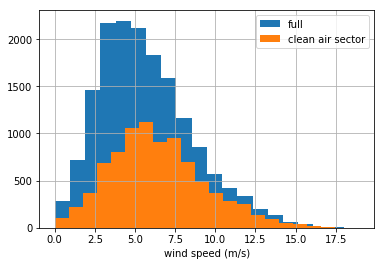

In [9]:
full.wind_speed.hist(bins=20, label='full')
clean.wind_speed.hist(bins=20, label='clean air sector')
plt.xlabel('wind speed (m/s)')
plt.legend()

<h3>Remove low wind speeds less than 3 m/s

In [10]:
clean = clean.loc[clean.wind_speed>3]

Text(0, 0.5, 'CFC-11 (ppt)')

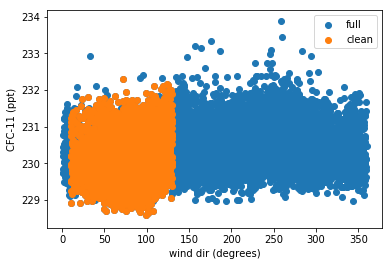

In [11]:
plt.scatter(full.wind_dir, full.brw_mr, label='full')
plt.scatter(clean.wind_dir, clean.brw_mr, label='clean')
plt.legend()
plt.xlabel('wind dir (degrees)')
plt.ylabel('CFC-11 (ppt)')

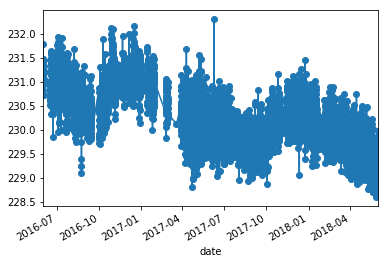

In [12]:
clean.brw_mr.plot(marker='o')

In [13]:
print(f"Number of measurements full:{full.shape[0]} clean:{clean.shape[0]}")

Number of measurements full:16175 clean:7725


<h2>Select Sunday data between 8-10 GMT or 0-2 local

In [20]:
clean2 = clean.loc[full.wind_speed>3]
clean2.reset_index(inplace=True)
# select hours and weekday
clean2 = clean2.assign(hh=(clean2.date.dt.hour==8)|(clean2.date.dt.hour==9))
clean2 = clean2.assign(week=(clean2.date.dt.weekday_name == 'Sunday'))
clean2 = clean2.loc[(clean2.hh==True)&(clean2.week==True)]

# if more than one data point, select the first
clean2 = clean2.assign(dd=clean2.date.diff()>datetime.timedelta(0,4000))
clean2 = clean2.loc[clean2.dd==True]
clean2.set_index(clean2.date, inplace=True)
clean2.drop(['hh','dd','week','date'], axis=1, inplace=True)

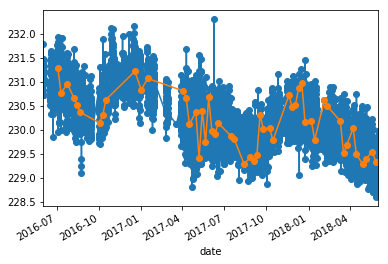

In [21]:
clean.brw_mr.plot(marker='o')
clean2.brw_mr.plot(marker='o')

In [22]:
print(f"Number of measurements full:{full.shape[0]} clean:{clean.shape[0]} clean2:{clean2.shape[0]}")

Number of measurements full:16175 clean:7725 clean2:52


In [23]:
full.to_csv('brw-full.csv')
clean.to_csv('brw-clean.csv')
clean2.to_csv('brw-clean-sunday.csv')